In [1]:
import sys
import glob

import pandas as pd
from pandas import DataFrame
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
def key_to_nice_name(key):
    return {
        "HIGH_ENTROPY": "Entropy",
        "CERTAINTY": "Pref Certainty",
        "UNCERTAINTY": "Active-R-Uncertainty",
        "OFFLINE": "Offline-Random",
        "RANDOM": "Random",
        "HIGH_ENTROPY_AND_CERTAINTY": "Entropy + Pref Certainty",
    }[key]

def load_data(file_pattern: str)-> DataFrame:
    dfs = []
    for f in glob.glob(f"../results/{file_pattern}"):
        print(f)
        df = pd.read_csv(f)    
        m = int(f.split("/")[-1].split("-")[4][1:])
        df["m"] = m
        dfs.append(df)
    
    return pd.concat(dfs)


In [3]:
def analyse(file_pattern, title=None):
    df = load_data(file_pattern)
    mean_win = df.groupby(["acquire_pairs_function", "m"]).win.mean().unstack()
    std = df.groupby(["acquire_pairs_function", "m", "seed"]).win.mean().groupby(["acquire_pairs_function", "m"]).std().unstack()
    n = df.groupby(["acquire_pairs_function", "m", "seed"]).win.mean().groupby(["acquire_pairs_function", "m"]).count().unstack()
    c = df.groupby(["acquire_pairs_function", "m"]).win.count().unstack() / n
    stderr = std / (n**0.5)

    if title is not None:
        print("=========================================")
        print(f" {title}") 
        print("=========================================")
    
    print("============= WIN RATE ============")
    display(mean_win)
    print("============= STD ERR ============")
    display(stderr)
    # print("============= STD ============")
    # display(std)
    # print("============= NUM SEEDS ============")
    # display(n)
    # print("============= EVAL DATAPOINTS PER SEED ============")
    # display(c)
    
    # colors = matplotlib.colormaps["Set1"]
    # fig, ax = plt.subplots(figsize=(10, 8))
    # 
    # mean_win_per_seed = df.groupby(["acquire_pairs_function", "m", "seed"]).win.mean().reset_index()
    # 
    # for i, apf in enumerate(sorted(set(df["acquire_pairs_function"]))):
    #     data = mean_win_per_seed[mean_win_per_seed.acquire_pairs_function == apf]
    #     ax.scatter(data["m"], data["win"], color=colors(i), marker="x", alpha=0.5, s=8)
    #     line_data = pd.DataFrame(data.groupby("m").win.mean())
    #     line_data["std"] = data.groupby("m").win.std()
    #     line_data["stderr"] = line_data["std"] / data.groupby("m").win.count()**0.5 
    #     line_data = line_data.reset_index()
    #         
    #     ax.errorbar(line_data["m"], line_data["win"], yerr=line_data["stderr"], capsize=5, c=colors(i), label=apf)
    #     #display(line_data)
    # 
    # ax.legend();
    
    

In [8]:
def boxplot(title: str, file_pattern: str)-> None:
    df = load_data(file_pattern=file_pattern)
    df_filtered = df[df['acquire_pairs_function'].isin(['CERTAINTY', 'RANDOM', 'HIGH_ENTROPY_AND_CERTAINTY', 'HIGH_ENTROPY'])]
    df_filtered['win'] = df_filtered['win'].astype(int)
    # filter out rows where m = 0:
    df_filtered = df_filtered[df_filtered['m'] != 0]
    df_filtered = df_filtered.groupby(['m', 'acquire_pairs_function', 'seed']).mean().reset_index()
    df_filtered.head()
    sns.set_style("whitegrid")  # Set plot style
    palette = {'RANDOM': 'grey', 'CERTAINTY': 'green', 'HIGH_ENTROPY_AND_CERTAINTY': 'red', 'HIGH_ENTROPY': 'blue' }
    order = ['RANDOM', 'HIGH_ENTROPY','CERTAINTY', 'HIGH_ENTROPY_AND_CERTAINTY']

    plt.figure(figsize=(10, 8))  # Set same width and height
    sns.boxplot(data=df_filtered, x="m", y="win", hue="acquire_pairs_function", width=0.5,
                palette=palette,
                hue_order=order,
                )  # Set width of boxplot

    
    plt.xlabel('Acquired dataset size', fontsize=20)
    plt.ylabel('Win rate vs initial model', fontsize=20)
    plt.xticks(fontsize=16)  # Increase fontsize for x-axis tick labels
    plt.yticks(fontsize=16)  # Increase fontsize for y-axis tick labels

    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [key_to_nice_name(label) for label in labels]
    plt.legend(handles, labels, title='Acquisition', fontsize=16, title_fontsize=16)

    plt.title(title, fontsize=20)
    
    plt.savefig(f"paper_{title}_acq_winrate_box_plot.png", dpi=300)
    plt.tight_layout()  # Adjust layout to fit plot properly
    plt.show()

In [17]:
def pointplot(title: str, file_pattern: str, legend:bool=True, vs="Initial model")-> None:
    df = load_data(file_pattern=file_pattern)
    df_filtered = df[df['acquire_pairs_function'].isin(['CERTAINTY', 'RANDOM',  'HIGH_ENTROPY_AND_CERTAINTY', 'HIGH_ENTROPY'])]
    df_filtered['win'] = df_filtered['win'].astype(int)
    # filter out rows where m = 0:
    df_filtered = df_filtered[df_filtered['m'] != 0]
    df_filtered = df_filtered.groupby(['m', 'acquire_pairs_function', 'seed']).mean().reset_index()
    df_filtered.head()
    sns.set_style("whitegrid")  # Set plot style
    palette = {'RANDOM': 'grey', 'CERTAINTY': 'green', 'HIGH_ENTROPY_AND_CERTAINTY': 'red', 'HIGH_ENTROPY': 'blue' }
    order = ['RANDOM', 'HIGH_ENTROPY','CERTAINTY', 'HIGH_ENTROPY_AND_CERTAINTY']

    plt.figure(figsize=(10, 8))  # Set same width and height
    sns.pointplot(data=df_filtered, x="m", y="win", hue="acquire_pairs_function",
                palette=palette,
                hue_order=order,
                errorbar="se",
                dodge=0.1,  # Adjust dodge to separate points along x-axis
                ) 

    
    plt.xlabel('Acquired dataset size', fontsize=20)
    plt.ylabel(f'Win rate vs {vs}', fontsize=20)
    plt.xticks(fontsize=16)  # Increase fontsize for x-axis tick labels
    plt.yticks(fontsize=16)  # Increase fontsize for y-axis tick labels
    
    if legend:
        handles, labels = plt.gca().get_legend_handles_labels()
        labels = [key_to_nice_name(label) for label in labels]
        plt.legend(handles, labels, title='Acquisition', fontsize=14, title_fontsize=14)
    else:
        plt.legend([],[], frameon=False)

    plt.title(title, fontsize=20)
    
    plt.savefig(f"paper_{title}_acq_winrate_point_plot.png", dpi=300)
    plt.tight_layout()  # Adjust layout to fit plot properly
    plt.show()

../results/post-eval-winrate-imdb-m128-xmas-sweep2.csv.1717081417.9785426
../results/post-eval-winrate-imdb-m256-xmas-sweep2.csv
../results/post-eval-winrate-imdb-m768-xmas-sweep2.csv.1717086519.2806513
../results/post-eval-winrate-imdb-m512-xmas-sweep2.csv.1717084756.4234529
../results/post-eval-winrate-imdb-m256-xmas-sweep2.csv.1717083136.6692934
../results/post-eval-winrate-imdb-m512-xmas-sweep2.csv
../results/post-eval-winrate-imdb-m128-xmas-sweep2.csv
../results/post-eval-winrate-imdb-m768-xmas-sweep2.csv
 IMDB
============= WIN RATE ============


m,128,256,512,768
acquire_pairs_function,,,,
CERTAINTY,0.675781,0.816189,0.874783,0.901042
HIGH_ENTROPY,0.681803,0.737630,0.840820,0.890462
HIGH_ENTROPY_AND_CERTAINTY,0.680990,0.812174,0.894097,0.915473
RANDOM,0.670464,0.760525,0.845703,0.882161


============= STD ERR ============


m,128,256,512,768
acquire_pairs_function,,,,
CERTAINTY,0.003148,0.004786,0.007216,0.003521
HIGH_ENTROPY,0.011404,0.009287,0.009285,0.004312
HIGH_ENTROPY_AND_CERTAINTY,0.003930,0.007491,0.006302,0.005371
RANDOM,0.011509,0.008925,0.004939,0.004238


../results/post-eval-winrate-imdb-m128-xmas-sweep2.csv.1717081417.9785426
../results/post-eval-winrate-imdb-m256-xmas-sweep2.csv
../results/post-eval-winrate-imdb-m768-xmas-sweep2.csv.1717086519.2806513
../results/post-eval-winrate-imdb-m512-xmas-sweep2.csv.1717084756.4234529
../results/post-eval-winrate-imdb-m256-xmas-sweep2.csv.1717083136.6692934
../results/post-eval-winrate-imdb-m512-xmas-sweep2.csv
../results/post-eval-winrate-imdb-m128-xmas-sweep2.csv
../results/post-eval-winrate-imdb-m768-xmas-sweep2.csv


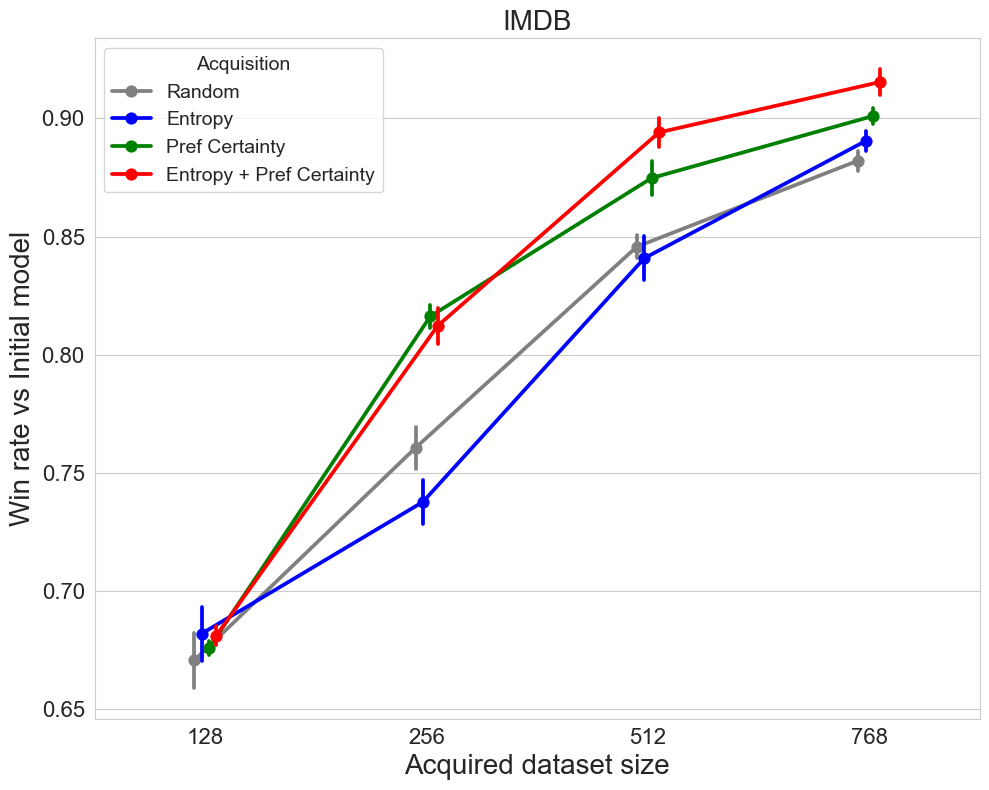

In [19]:
analyse("post-eval-winrate-imdb-m*-xmas-sweep2.csv*", "IMDB")
# boxplot("IMDB", "post-eval-winrate-imdb-m*-xmas-sweep2.csv")
pointplot("IMDB", "post-eval-winrate-imdb-m*-xmas-sweep2.csv*")


../results/post-eval-winrate-tldr-m256-xmas-sweep2.csv
../results/post-eval-winrate-tldr-m512-xmas-sweep2.csv.1717151010.3497448
../results/post-eval-winrate-tldr-m384-xmas-sweep2.csv
../results/post-eval-winrate-tldr-m0-xmas-sweep2.csv
../results/post-eval-winrate-tldr-m128-xmas-sweep2.csv.1717145431.1338885
../results/post-eval-winrate-tldr-m256-xmas-sweep2.csv.1717147291.832279
../results/post-eval-winrate-tldr-m512-xmas-sweep2.csv
../results/post-eval-winrate-tldr-m128-xmas-sweep2.csv
../results/post-eval-winrate-tldr-m384-xmas-sweep2.csv.1717149145.5653675
 TLDR
============= WIN RATE ============


m,0,128,256,384,512
acquire_pairs_function,,,,,
CERTAINTY,NaN,0.523763,0.561849,0.584744,0.600369
HIGH_ENTROPY,NaN,0.510742,0.565592,0.559082,0.580566
HIGH_ENTROPY_AND_CERTAINTY,NaN,0.528537,0.546224,0.592665,0.592339
RANDOM,0.394206,0.510200,0.550998,0.550564,0.560764


============= STD ERR ============


m,0,128,256,384,512
acquire_pairs_function,,,,,
CERTAINTY,NaN,0.011730,0.011786,0.009947,0.008984
HIGH_ENTROPY,NaN,0.012798,0.009646,0.016950,0.010214
HIGH_ENTROPY_AND_CERTAINTY,NaN,0.005567,0.009509,0.006927,0.009559
RANDOM,0.002966,0.007517,0.010700,0.008515,0.010705


../results/post-eval-winrate-tldr-m256-xmas-sweep2.csv
../results/post-eval-winrate-tldr-m512-xmas-sweep2.csv.1717151010.3497448
../results/post-eval-winrate-tldr-m384-xmas-sweep2.csv
../results/post-eval-winrate-tldr-m0-xmas-sweep2.csv
../results/post-eval-winrate-tldr-m128-xmas-sweep2.csv.1717145431.1338885
../results/post-eval-winrate-tldr-m256-xmas-sweep2.csv.1717147291.832279
../results/post-eval-winrate-tldr-m512-xmas-sweep2.csv
../results/post-eval-winrate-tldr-m128-xmas-sweep2.csv
../results/post-eval-winrate-tldr-m384-xmas-sweep2.csv.1717149145.5653675


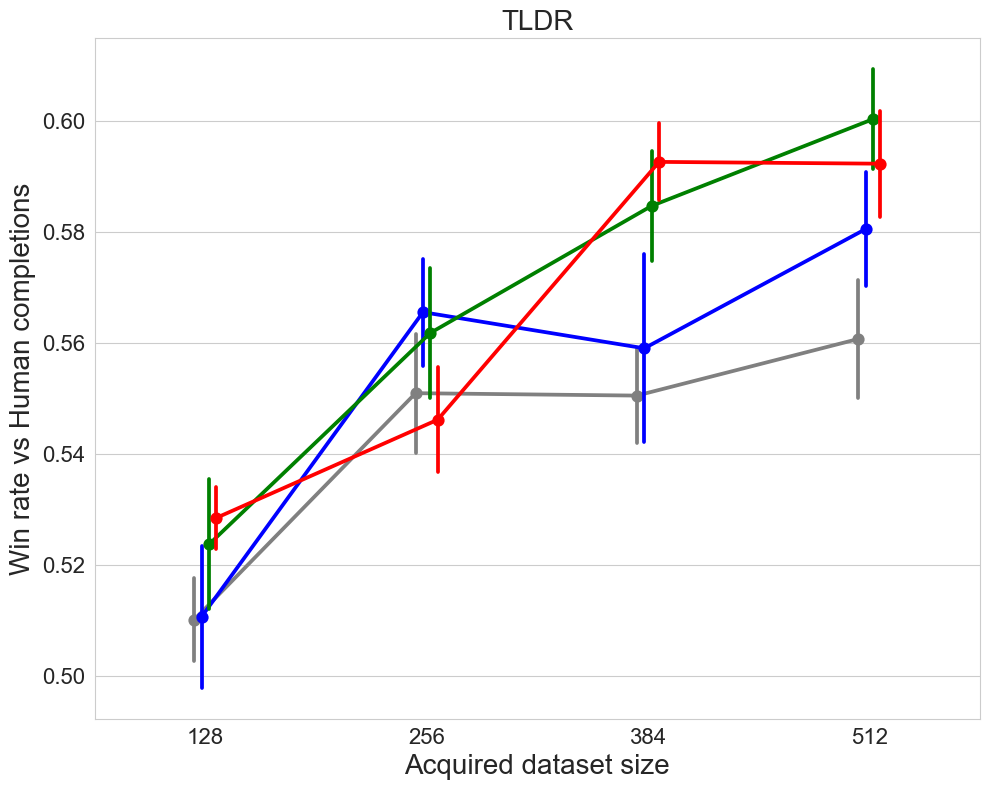

In [22]:
analyse("post-eval-winrate-tldr-m*-xmas-sweep2.csv*", "TLDR")
# boxplot("TLDR", "post-eval-winrate-tldr-m*-xmas-sweep2.csv")
pointplot("TLDR", "post-eval-winrate-tldr-m*-xmas-sweep2.csv*", False, "Human completions")



../results/post-eval-winrate-imdb-m512-xmas-lora.csv
../results/post-eval-winrate-imdb-m768-xmas-lora.csv
../results/post-eval-winrate-imdb-m256-xmas-lora.csv
 IMDB - LoRA, RMSprop, 10 epochs per training cycle
============= WIN RATE ============


m,256,512,768
acquire_pairs_function,,,
CERTAINTY,0.838108,0.876519,0.90408
RANDOM,0.861762,0.894965,0.90625


============= STD ERR ============


m,256,512,768
acquire_pairs_function,,,
CERTAINTY,0.012077,0.011392,0.006481
RANDOM,0.009573,0.008776,0.008668


============= NUM SEEDS ============


m,256,512,768
acquire_pairs_function,,,
CERTAINTY,9,9,9
RANDOM,9,9,9


============= EVAL DATAPOINTS PER SEED ============


m,256,512,768
acquire_pairs_function,,,
CERTAINTY,512.0,512.0,512.0
RANDOM,512.0,512.0,512.0


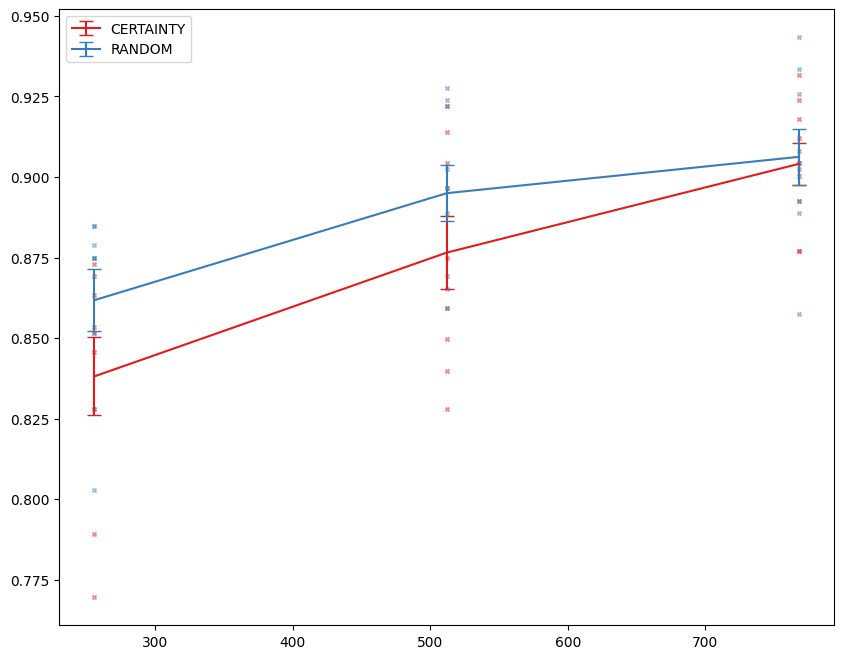

In [79]:
analyse("post-eval-winrate-imdb-m*-xmas-lora.csv", "IMDB - LoRA, RMSprop, 10 epochs per training cycle")